In [1]:
import pandas as pd

pd.options.display.max_columns = 999

In [2]:
train_data = pd.read_csv('../data/train_processed.csv')
submission_data = pd.read_csv('../data/CAX_LogFacies_Submission_File.csv')

In [3]:
test_data = pd.read_csv('../data/test_processed.csv')

In [4]:
train_data.head(5)

,row_id,well_id,GR,label,processed_GR,processed_GR2
0,0,0,143.510000,0,0.816197,1.042664
1,1,0,112.790928,0,0.609702,0.066697
2,2,0,123.531856,0,0.681903,0.407944
3,3,0,111.692784,0,0.602320,0.031808
4,4,0,123.613712,0,0.682453,0.410545


In [5]:
df = train_data.groupby(['well_id','label'])['row_id'].count().reset_index()

In [6]:
df.head(10)

,well_id,label,row_id
0,0,0,642
1,0,1,105
2,0,2,195
3,0,3,76
4,0,4,82
5,1,0,508
6,1,1,135
7,1,2,54
8,1,3,331
9,1,4,72


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

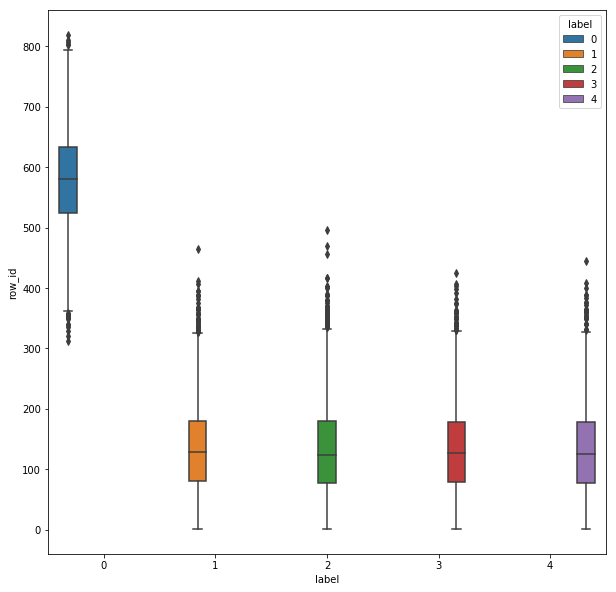

In [8]:
plt.figure(figsize=(10,10))
sns.boxplot(x=df.label,y=df.row_id,hue=df.label)
plt.show()

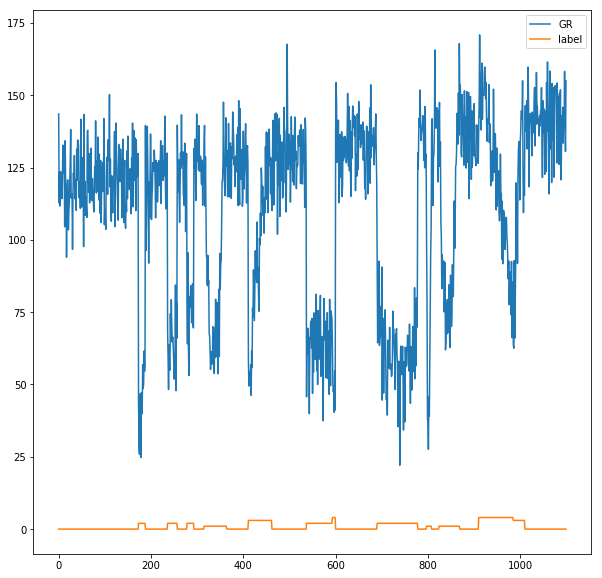

In [9]:
plt.figure(figsize=(10,10))
plt.plot(train_data[train_data.well_id == 0].row_id,train_data[train_data.well_id == 0].GR)
plt.plot(train_data[train_data.well_id == 0].row_id,train_data[train_data.well_id == 0].label)
plt.legend()
plt.show()

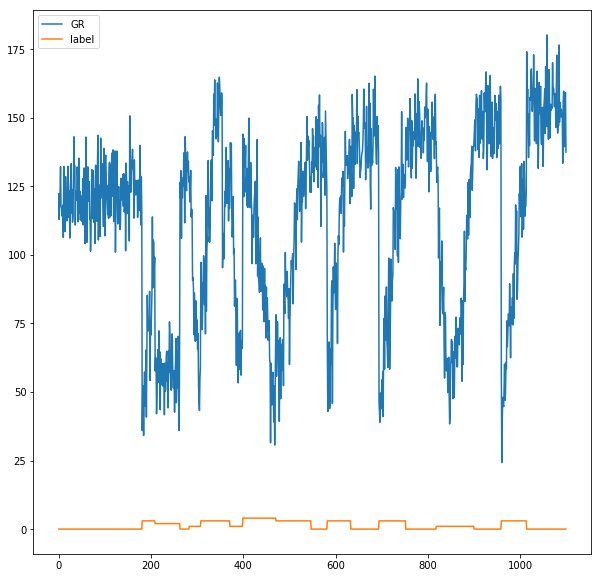

In [10]:
plt.figure(figsize=(10,10))
plt.plot(train_data[train_data.well_id == 1].row_id,train_data[train_data.well_id == 1].GR)
plt.plot(train_data[train_data.well_id == 1].row_id,train_data[train_data.well_id == 1].label)
plt.legend()
plt.show()

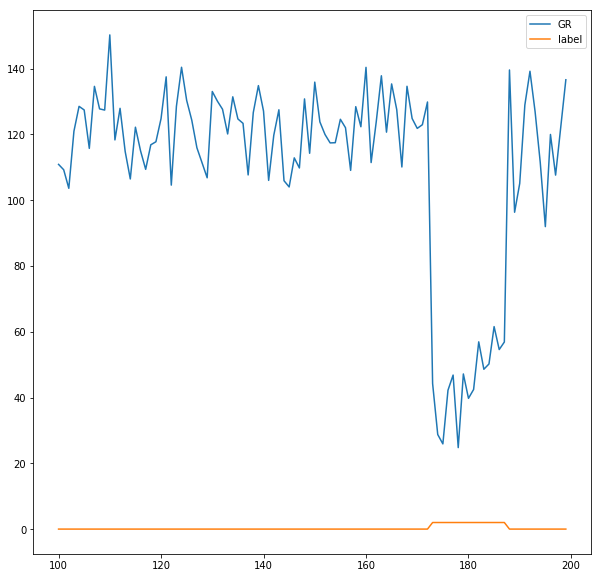

In [11]:
plt.figure(figsize=(10,10))
plt.plot(train_data[train_data.well_id == 0].row_id.iloc[100:200],train_data[train_data.well_id == 0].GR.iloc[100:200])
plt.plot(train_data[train_data.well_id == 0].row_id.iloc[100:200],train_data[train_data.well_id == 0].label.iloc[100:200])
plt.legend()
plt.show()

In [12]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

/Users/victor/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [13]:
'''
# Create a training file with simple derived features
rows = train_data[train_data.well_id == 0].shape[0]

segments = int(np.floor(train_data.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
'''

"\n# Create a training file with simple derived features\nrows = train_data[train_data.well_id == 0].shape[0]\n\nsegments = int(np.floor(train_data.shape[0] / rows))\n\ndef add_trend_feature(arr, abs_values=False):\n    idx = np.array(range(len(arr)))\n    if abs_values:\n        arr = np.abs(arr)\n    lr = LinearRegression()\n    lr.fit(idx.reshape(-1, 1), arr)\n    return lr.coef_[0]\n\ndef classic_sta_lta(x, length_sta, length_lta):\n    \n    sta = np.cumsum(x ** 2)\n\n    # Convert to float\n    sta = np.require(sta, dtype=np.float)\n\n    # Copy for LTA\n    lta = sta.copy()\n\n    # Compute the STA and the LTA\n    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]\n    sta /= length_sta\n    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]\n    lta /= length_lta\n\n    # Pad zeros\n    sta[:length_lta - 1] = 0\n\n    # Avoid division by zero by setting zero values to tiny float\n    dtiny = np.finfo(0.0).tiny\n    idx = lta < dtiny\n    lta[idx] = dtiny\n\n    retur

In [14]:
train_data[train_data.well_id == 0].processed_GR.head(5)

0    0.816196856685592
1    0.609702206982171
2    0.681903092390077
3    0.602320447098181
4    0.682453332781807
Name: processed_GR, dtype: float64

In [15]:
#train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(2).mean().iloc[::-1]

In [16]:
#train_data.groupby('well_id')['processed_GR'].rolling(2).mean()

In [18]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [19]:
#calculate_slope(np.array([0.8161968566855917, 0.6097022069821709]).reshape(-1,1))

In [20]:
#train_data.groupby(['well_id'])['processed_GR'].rolling(2).apply(calculate_slope)

In [21]:
def calculate_slope(input_list):
    X = [x for x in input_list if np.isnan(x) == False]
    lr = LinearRegression()
    if len(X) > 1:
        lr.fit(np.arange(len(X)).reshape(-1,1),np.array(X).reshape(-1,1))
        return lr.coef_[0][0]
    else:
        return 0

In [22]:
for w in tqdm([5,10,50,100,250,500]):
    
    train_data["rolling_mean_{}".format(w)] = train_data.groupby(['well_id'])['processed_GR'].rolling(w).mean().values
    train_data["rolling_min_{}".format(w)] = train_data.groupby(['well_id'])['processed_GR'].rolling(w).min().values
    train_data["rolling_max_{}".format(w)] = train_data.groupby(['well_id'])['processed_GR'].rolling(w).max().values
    train_data["rolling_std_{}".format(w)] = train_data.groupby(['well_id'])['processed_GR'].rolling(w).std().values
    train_data["rolling_med_{}".format(w)] = train_data.groupby(['well_id'])['processed_GR'].rolling(w).median().values
    #train_data["rolling_slope_{}".format(w)] = train_data.groupby(['well_id'])['processed_GR'].rolling(w).apply(lambda x: calculate_slope(x))

    train_data["rolling_forward_mean_{}".format(w)] = train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).mean().iloc[::-1].values
    train_data["rolling_forward_min_{}".format(w)] = train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).min().iloc[::-1].values
    train_data["rolling_forward_max_{}".format(w)] = train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).max().iloc[::-1].values
    train_data["rolling_forward_std_{}".format(w)] = train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).std().iloc[::-1].values
    train_data["rolling_forward_med_{}".format(w)] = train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).median().iloc[::-1].values
    #train_data["rolling_forward_slope_{}".format(w)] = train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).apply(calculate_slope).iloc[::-1]

100%|██████████| 6/6 [04:40<00:00, 53.33s/it]


In [23]:
for w in tqdm([5,10,50,100,250,500]):
    
    test_data["rolling_mean_{}".format(w)] = test_data.groupby(['well_id'])['processed_GR'].rolling(w).mean().values
    test_data["rolling_min_{}".format(w)] = test_data.groupby(['well_id'])['processed_GR'].rolling(w).min().values
    test_data["rolling_max_{}".format(w)] = test_data.groupby(['well_id'])['processed_GR'].rolling(w).max().values
    test_data["rolling_std_{}".format(w)] = test_data.groupby(['well_id'])['processed_GR'].rolling(w).std().values
    test_data["rolling_med_{}".format(w)] = test_data.groupby(['well_id'])['processed_GR'].rolling(w).median().values
    #test_data["rolling_slope_{}".format(w)] = test_data.groupby(['well_id'])['processed_GR'].rolling(w).apply(lambda x: calculate_slope(x))

    test_data["rolling_forward_mean_{}".format(w)] = test_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).mean().iloc[::-1].values
    test_data["rolling_forward_min_{}".format(w)] = test_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).min().iloc[::-1].values
    test_data["rolling_forward_max_{}".format(w)] = test_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).max().iloc[::-1].values
    test_data["rolling_forward_std_{}".format(w)] = test_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).std().iloc[::-1].values
    test_data["rolling_forward_med_{}".format(w)] = test_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).median().iloc[::-1].values
    #test_data["rolling_forward_slope_{}".format(w)] = test_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).apply(calculate_slope).iloc[::-1]

100%|██████████| 6/6 [1:19:28<00:00, 1305.12s/it]


In [22]:
for w in tqdm([5,10,50,100,250,500]):
    
    train_data["rolling_slope_{}".format(w)] = train_data.groupby(['well_id'])['processed_GR'].rolling(w).apply(lambda x: calculate_slope(x))
    train_data["rolling_forward_slope_{}".format(w)] = train_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).apply(calculate_slope).iloc[::-1]

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for w in tqdm([5,10,50,100,250,500]):
    
    test_data["rolling_slope_{}".format(w)] = test_data.groupby(['well_id'])['processed_GR'].rolling(w).apply(lambda x: calculate_slope(x))
    test_data["rolling_forward_slope_{}".format(w)] = test_data.iloc[::-1].groupby('well_id', sort=False)['processed_GR'].rolling(w).apply(calculate_slope).iloc[::-1]

In [29]:
#train_data = train_data.interpolate(method='nearest')
#test_data = test_data.interpolate(method='nearest')

In [24]:
for col in train_data.columns:
    train_data[col] = train_data[col].fillna(method='bfill')

In [25]:
for col in test_data.columns:
    test_data[col] = test_data[col].fillna(method='bfill')

In [ ]:
for col in train_data.columns:
    if "rolling" in col and "difference" not in col:
        train_data["difference_{}".format(col)] = train_data.processed_GR - train_data[col]
        test_data["difference_{}".format(col)] = test_data.processed_GR - test_data[col]

In [ ]:
train_data.columns

Index(['row_id', 'well_id', 'GR', 'label', 'processed_GR', 'processed_GR2',
       'rolling_mean_5', 'rolling_min_5', 'rolling_max_5', 'rolling_std_5',
       ...
       'difference_rolling_mean_500', 'difference_rolling_min_500',
       'difference_rolling_max_500', 'difference_rolling_std_500',
       'difference_rolling_med_500', 'difference_rolling_forward_mean_500',
       'difference_rolling_forward_min_500',
       'difference_rolling_forward_max_500',
       'difference_rolling_forward_std_500',
       'difference_rolling_forward_med_500'],
      dtype='object', length=126)

In [ ]:
traincols = list(train_data.columns)[4:]
print (len(traincols))

122


In [44]:
#train_data.to_csv('../input/train_processed.csv',index=False)
#test_data.to_csv("../input/test_processed.csv",index=False)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [ ]:
for train_index, test_index in GroupKFold(n_splits=5).split(train_data[traincols],train_data.label,train_data.well_id):
    break

In [ ]:
train_index

array([      0,       1,       2, ..., 4398897, 4398898, 4398899])

In [ ]:
test_index

array([   3300,    3301,    3302, ..., 4399997, 4399998, 4399999])

In [ ]:
model = LogisticRegression() #GradientBoostingClassifier(n_estimators=100) #RandomForestClassifier(n_estimators=100)
model.fit(train_data[traincols].iloc[train_index].values,train_data.label.iloc[train_index].values)

In [ ]:
pred = model.predict(train_data[traincols].iloc[test_index])

In [ ]:
print (accuracy_score(train_data.label.iloc[test_index], pred))
print (f1_score(train_data.label.iloc[test_index], pred, average='macro'))
print (confusion_matrix(train_data.label.iloc[test_index], pred))

In [41]:
from sklearn.externals import joblib

In [42]:
#joblib.dump(model,'rf.pkl')

In [43]:
import eli5

In [45]:
#weights = eli5.explain_weights_df(model,feature_names=traincols)

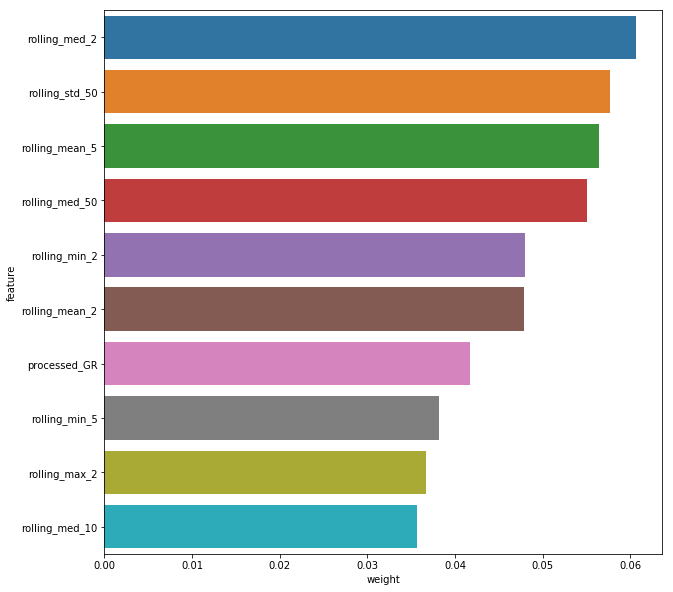

In [46]:
#weights = weights[weights.weight > 0]

#plt.figure(figsize=(10,10))
#sns.barplot(y='feature',x='weight',data=weights.iloc[:10],)
#plt.show()

In [45]:
import lightgbm as lgb

In [46]:
dtrain = lgb.Dataset(train_data[traincols].iloc[train_index],train_data.label.iloc[train_index])

In [47]:
dval = lgb.Dataset(train_data[traincols].iloc[test_index],train_data.label.iloc[test_index])

In [54]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':5,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    "verbosity": 0}

In [55]:
model2 = lgb.train(params, dtrain, num_boost_round=500, valid_sets=[dval], early_stopping_rounds=100, verbose_eval=10)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's multi_logloss: 16.4199
[20]	valid_0's multi_logloss: 16.4199
[30]	valid_0's multi_logloss: 16.4199
[40]	valid_0's multi_logloss: 16.4199
[50]	valid_0's multi_logloss: 16.4199
[60]	valid_0's multi_logloss: 16.4199
[70]	valid_0's multi_logloss: 16.4199
[80]	valid_0's multi_logloss: 16.4199
[90]	valid_0's multi_logloss: 16.4199
[100]	valid_0's multi_logloss: 16.4199
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 16.4199


In [58]:
pred = model2.predict(train_data[traincols].iloc[test_index])

MemoryError: Unable to allocate array with shape (141, 4400000) and data type float64